In [66]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score
from sklearn.base import clone, BaseEstimator

In [2]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

# Observe MNIST Dataset

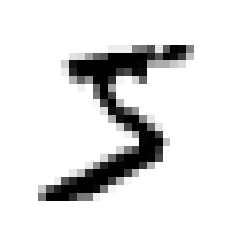

In [3]:
X,y = mnist['data'], mnist['target']
X = np.array(X)

X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

plt.imshow(X[0].reshape(28,28),cmap = 'binary')
plt.axis('off')
plt.show()

# Cast categories as integers

In [4]:
y_train_5 = (y_train.astype(np.uint8) == 5)
y_test_5 = (y_test.astype(np.uint8) == 5)

# Generate a SGD Classifier

In [42]:
my_sgd = SGDClassifier(random_state=42)
my_sgd.fit(X_train,y_train_5)

y_preds = my_sgd.predict(X_test)
print()

# Perform SK Folding for better training/testing

In [43]:
skfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=42)
for train_index, test_index in skfold.split(X_train,y_train_5):
    sgd_clone = clone(my_sgd)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    sgd_clone.fit(X_train_folds,y_train_folds)
    tmp_preds = sgd_clone.predict(X_test_folds)
    
    n_correct = sum(tmp_preds == y_test_folds)
    print(n_correct / len(tmp_preds))

0.9669
0.91625
0.96785


# Scoring vs Predicting - Metrics in Classification Tasks

In [8]:
cross_val_score(clone(my_sgd),X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [9]:
class NeverSClassifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [10]:
cross_val_score(NeverSClassifier(),X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Why is scoring a poor metric in classification - 

In the example above, we can achieve 90% of accuracy by always predicting that it's never 5. This is since out of 10 numbers, 9 are not, so we have high scoring. This is why classification tasks rely on other metrics, starting with a confusion matrix.




Precision: The percentage of true positives out of the sum of true positives and false positives.

Recall: The percentage of true positives out of the sum of the true positives and the false negatives. 


In [11]:
y_train_preds = cross_val_predict(clone(my_sgd),X_train,y_train_5,cv = 3)
confusion_matrix(y_train_5,y_train_preds)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [12]:
ps = precision_score(y_train_5,y_train_preds)
rs = recall_score(y_train_5,y_train_preds)

print(ps)
print(rs)

0.8370879772350012
0.6511713705958311


## Out of the Recall and Precision, we can generate ROC curves, and F1 metric.

F1: 2 / ((1/PRECISION) + (1/RECALL))

In [13]:
print(f1_score(y_train_5, y_train_preds))
print(2/((1/ps)+(1/rs)))

0.7325171197343846
0.7325171197343847


In [45]:
y_scores = my_sgd.decision_function(X[0].reshape(1,-1))
thresh = 0

print (y_scores > thresh)


[ True]


In [47]:
y_scores = cross_val_predict(my_sgd,X_train,y_train_5,cv=3,method='decision_function')
prs,recs,thresh = precision_recall_curve(y_train_5,y_scores)

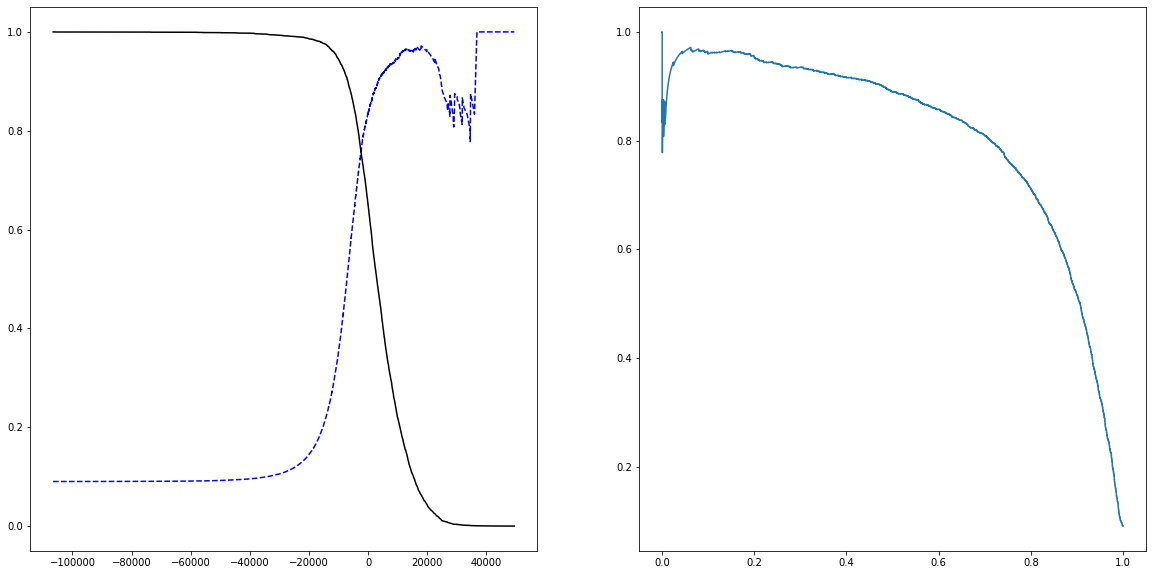

In [50]:
_,ax = plt.subplots(ncols=2,figsize=(20,10))
ax[0].plot(thresh,prs[:-1],'--b',label='Precision')
ax[0].plot(thresh,recs[:-1],'k-',label='Recall')

ax[1].plot(recs[:-1],prs[:-1])

## ROC and AUC

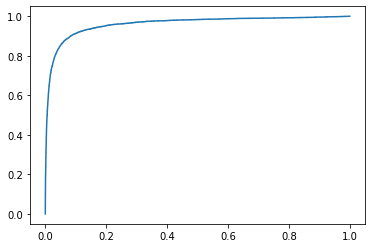

In [53]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

plt.plot(fpr,tpr)

In [67]:
roc_auc_score(y_train_5,y_scores) #roc score

0.9604938554008616

According to the book, we rather use the PR curve when we have a small amount of true positive cases, or when we care more about false positives rather than false negatives. (we care about the ability to be precise, rather than recall).

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv = 3, method= 'predict_proba')

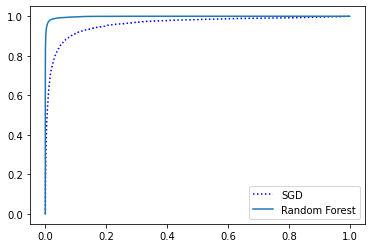

In [70]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr,'b:',label='SGD')
plt.plot(fpr_forest,tpr_forest,label='Random Forest')
plt.legend(loc = 'lower right')

In [73]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [77]:
pr_forest, re_forest, thresh_forest = precision_recall_curve(y_train_5,y_scores_forest)


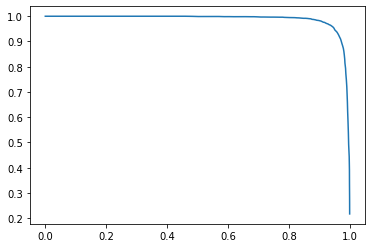

In [78]:
plt.plot(re_forest,pr_forest)

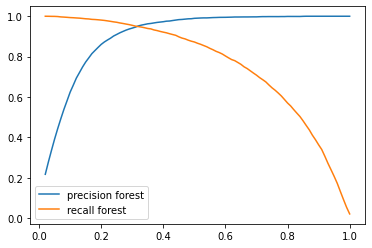

In [81]:
plt.plot(thresh_forest,pr_forest[:-1],label= 'precision forest')
plt.plot(thresh_forest,re_forest[:-1],label='recall forest')
plt.legend()

In [87]:
print(precision_score(y_train_5,y_probas_forest[:,1] > .5))
print(recall_score(y_train_5,y_probas_forest[:,1] > .5))

0.9905083315756169
0.8662608374838591


## Multi Class Classifiers

SVMs and SGD classifiers are only binary - to do multi class, we can train multiple binary classifiers and then select the highest scoring one.

OVO - one versus one - binary classifier that distinguishes between 2 classes (i.e., 0 v 1, 0 v 2, 1 v 2, etc...) (N x (N-1) ) / 2 total classifiers.However, it only has to be trained on smaller batches of data

OVA - one versus all - binary classifiers that distinguishes if between a class and the rest (i.e., is 0 or no?). Less number of classifiers, however needs the full dataset.

In [88]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)


NameError: name 'svm' is not defined

In [94]:
svm_clf.predict(X_test[0].reshape(1,-1))

scores = svm_clf.decision_function(X_test[0].reshape(1,-1))
print(scores)

[[ 3.80895496 -0.30212376  6.19343167  8.29375992  1.71167996  4.76436748
   0.69153837  9.31783975  2.75699419  7.28292338]]


In [96]:
from sklearn.multiclass import OneVsRestClassifier

over_clf = OneVsRestClassifier(SVC())
over_clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC())

In [97]:
cross_val_score(over_clf,X_train,y_train,cv= 3,scoring='accuracy') 

array([0.97685, 0.9738 , 0.97495])

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

cross_val_score(over_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.9616 , 0.95895, 0.96205])

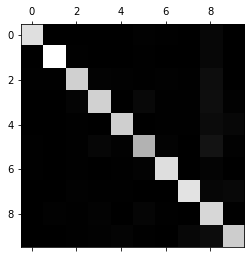

In [99]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train,y_train)

y_train_pred = cross_val_predict(sgd_clf,X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train,y_train_pred)

plt.matshow(conf_mx, cmap = plt.cm.gray)


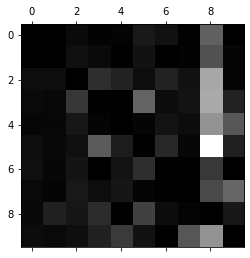

In [101]:
norm_conf_mx = conf_mx / conf_mx.sum(axis=1,keepdims=True)
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)
